In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector

from scipy.stats import multivariate_normal

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp

# data generation

In [2]:
# ===================== linear model =====================================================
# def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
#     "Generates data matrix X and observations Y."
#     np.random.seed(seed)
#     # beta_star = np.random.randn(n)
#     # beta_star[8:] = 0
#     beta_star = np.zeros(n)
#     beta_star[:num_support] = signal
#     X = np.random.randn(m,n)
#     Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
#     return X, Y, beta_star, np.diag(np.ones(n))

# ===================== covariates with correlations ====================================
# def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
#     "Generates data matrix X and observations Y."
#     np.random.seed(seed)
        
#     mean = np.random.uniform(-5, 5, n)
#     cov = np.ones((n, n))
#     for i in range(n):
#         for j in range(n):
#             cov[i, j] = 0.8**abs(i-j)
#     X = np.random.multivariate_normal(mean, cov, m)
    
#     beta_star = np.zeros(n)
#     beta_star[:num_support] = signal
    
#     Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
#     return X, Y, beta_star, cov

# ===================== linear model with intersection =====================================================
def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
    "Generates data matrix X and observations Y."
    np.random.seed(seed)
    
    X = np.random.randn(m,n)
    X_s = X[:, :num_support]
    beta_star = np.array([signal] * 6)
    
    Y = beta_star[0] * X_s[:, 0] + beta_star[1] * X_s[:, 1] * X_s[:, 2] + \
        beta_star[2] * X_s[:, 3] + beta_star[3] * X_s[:, 4] * X_s[:, 5] + beta_star[4] * X_s[:, 6] + \
        beta_star[5] * X_s[:, 7] + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star, np.diag(np.ones(n))


# ===================== qudratic model =====================================================
# def generate_data(m=100, n=20, signal=1, sigma=1, num_support=8, seed=1):
#     '''
#     Generates data matrix X and observations Y.
#     @m: sample_size
#     @n: # covariates
#     @sigma: sigma of Gaussian distribution for generate X
#     @num_support: # covariate in true model
#     @seed: random seed
#     '''
    
#     np.random.seed(seed)
#     mean = np.random.uniform(-5, 5, n)
#     cov = np.diag(np.random.uniform(1, 3, n))
#     # cov = np.random.randn(n, n)
#     # cov = cov.dot(cov.T)
#     # cov = (cov - cov.min()) / (cov.max()-cov.min())
#     # cov = cov + np.diag(np.random.uniform(1, 3, n))
#     X = np.random.multivariate_normal(mean, cov, m)
#     # idx = np.random.choice(range(d), num_support, replace=False)
#     X_s = X[:, :num_support]
    
#     beta_star = np.array([signal] * num_support)
    
#     Y = np.dot(X_s[:,:4]**2, beta_star[:4]) + np.dot(X_s[:, 4:], beta_star[4:]) + np.random.normal(0, sigma, m) 
    
#     return X, Y, beta_star, cov


# ===================== Hierarchical model =====================================================
# def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
#     "Generates data matrix X and observations Y."
#     np.random.seed(seed)
#     X = np.random.randn(m, n)
#     X_s = X[:, :num_support]
    
#     W1 = np.random.randn(num_support, 32)
#     W2 = np.random.randn(32, )
#     Y = np.maximum(0, X_s.dot(W1)).dot(W2) + np.random.normal(0, sigma, size=m)
#     return X, Y, (W1, W2), np.diag(np.ones(n))

# Architecture

In [3]:
# ==============================================================================================
def get_data(x, y, batch_size=32):
#     x = StandardScaler(with_mean=True, with_std=True).fit_transform(x)
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :], y[idx, np.newaxis]



class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        '''
        obs_dim: dim_x or (dim_x + dim_y)
        action_dim: dim_x
        '''
        super(Actor, self).__init__()
        
        
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc2 = nn.Linear(256, action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Bernoulli(logits=logits)
        
        actions = m.sample()
        log_probs = m.log_prob(actions)
        entropy = m.entropy()
        
        return actions, log_probs, entropy


# class Critic(nn.Module):
#     def __init__(self, obs_dim):
        
#         super(Critic, self).__init__()
#         self.f1 = nn.Linear(in_features=obs_dim, out_features=128)
#         self.f2 = nn.Linear(in_features=128, out_features=1)
        
#     def forward(self, obs): 
#         obs = torch.tensor(obs, dtype=torch.float)
#         r_baseline = F.relu(self.f1(obs))
#         r_baseline = self.f2(r_baseline)        
#         return r_baseline


def compute_reward(X_train, Y_train, X_test, Y_test, actions, num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for action in actions.detach().numpy():
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
            regressor = MLPRegressor(hidden_layer_sizes=(128,), random_state=1, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01)
#             regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = regressor.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = 1 - score
            reward_list.append(1 - score)
        
    return np.array(reward_list)

# train

In [4]:
# training steps
m = 100
n = 24
sigma = 1
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=np.int)
y_true[:num_support] = 1


def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)   
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
    
    actor = Actor(obs_dim=n, action_dim=n)
    actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
    # critic = Critic(obs_dim=n)
    # critic_optimizer = optim.Adam(critic.parameters(), lr=3e-4)
        
    action_select = []
    dictionary = dict()
    r_list = []
    
    r_baseline = torch.tensor(0)
    
    for step in range(500):
        # print('step: ', step)
        
        X_train, Y_train = get_data(x_train, y_train, batch_size=64)
            
        actions, log_probs, entropy = actor(X_train)
        action_select.append(actions.detach().numpy().mean(axis=0))
        
        # r_baseline = critic(X_train)
        # r_baseline = r_baseline.squeeze()
        
        
        rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=1000, lr=1e-2, batch_size=64, dictionary=dictionary)
        r_list.append(rewards.mean())
        # print(f'average reward: {rewards.mean()}')
        rewards = torch.tensor(rewards, dtype=torch.float32)
        
        r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
        
        # update actor
        actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}')
        
        # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
        # actor_optimizer.zero_grad()
        # actor_loss.backward()
        # actor_optimizer.step()
        # print(f'actor loss: {actor_loss.item()}\n')
        
        # update critic
        # critic_loss = F.mse_loss(r_baseline, rewards)
        # critic_optimizer.zero_grad()
        # critic_loss.backward()
        # critic_optimizer.step()
        # print(f'critic loss: {critic_loss.item()}\n')
        
#         if step > 6:
#             if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
# #             print(f'converge at step {step}')
#                 break
    
    action_select = np.array(action_select)
            
    
    tmp = sorted(dictionary.items(), key=lambda x: x[1])
    s = set(range(n))
    for item in tmp[:10]:
        s = s & set(item[0])
    # print(s)
    
    with torch.no_grad():
        actions, log_probs, _ = actor(X)
                        
#     y_pred_rl1 = np.where(action_select[-10:].mean(axis=0) >= 0.9, 1, 0)
#     y_pred_rl2 = np.where(actions.mean(dim=0) >= 0.9, 1, 0)
    y_pred_rl1 = action_select[-10:].mean(axis=0)
    y_pred_rl2 = actions.mean(dim=0).numpy()
    y_pred_rl3 = np.where([i in s for i in range(n)], 1, 0)
    
    
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
    lasso_bic.fit(X, Y)
    y_pred_bic = np.where(lasso_bic.coef_ != 0, 1, 0)
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
    lasso_aic.fit(X, Y)
    y_pred_aic = np.where(lasso_aic.coef_ != 0, 1, 0)
    rf = RandomForestRegressor(max_depth=5, random_state=seed)    
    rf.fit(X, Y)
    sfm = SelectFromModel(rf, prefit=True)
    y_pred_sfm = np.where(sfm.get_support() != 0, 1, 0)
    
    dat = np.vstack((y_pred_rl1, y_pred_rl2, y_pred_rl3, y_pred_aic, y_pred_bic, y_pred_sfm))
    
    # cm1 = confusion_matrix(y_true, y_pred_rl1)
    # cm2 = confusion_matrix(y_true, y_pred_rl2)
    # cm_bic = confusion_matrix(y_true, y_pred_bic)
    # cm_aic = confusion_matrix(y_true, y_pred_aic)
    # # return cm1, cm2, cm_bic, cm_aic
    
    # dat = pd.DataFrame(np.zeros((3, 4)), index=['precision', 'specificity', 'recall'])
    #                     # columns=['cm1', 'cm2', 'bic', 'aic'])
    
    # for i, cm in enumerate([cm1, cm2, cm_bic, cm_aic]):
    #     tn, fp, fn, tp = cm.ravel()
    #     dat.loc['precision', i] = tp/(tp+fn)
    #     dat.loc['specificity', i] = tn/(tn+fp)
    #     dat.loc['recall', i] = 0 if tp + fp == 0 else tp/(tp+fp)
        
    # dat.columns = ['cm1', 'cm2', 'bic', 'aic']
    
    
#     regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     regr.fit(X, Y)
#     sfm = SelectFromModel(regr, prefit=True)
#     y_pred_log = np.where(sfm.get_support(), 1, 0)
    
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [ ]:
if __name__ == '__main__':   
    # results = []
    # for sd in tqdm(range(20)):
    #     results.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))
    start = time.time()
    pool = mp.Pool(4)
    dats = pool.map(run, range(50))
    pool.close()
    end = time.time()
    print(datetime.timedelta(seconds = end - start))
    
    
    dats = np.array([dat for dat in dats])

random seed: 12 is runningrandom seed: 8 is running

random seed: 0 is running
random seed: 4 is running
rd: 0 take 0:57:03.900443
random seed: 1 is running
rd: 12 take 0:57:19.967163
random seed: 13 is running
rd: 4 take 0:58:04.250608
random seed: 5 is running
rd: 8 take 0:59:04.569839
random seed: 9 is running
rd: 13 take 0:53:19.249757
random seed: 14 is running
rd: 1 take 1:00:57.139126
random seed: 2 is running
rd: 5 take 1:00:13.492683
random seed: 6 is running
rd: 9 take 1:00:16.755840
random seed: 10 is running
rd: 14 take 0:52:37.000922
random seed: 15 is running


In [13]:
np.save('./synthetic_data_analysis/results/m100_n24_linear_with_intercetion_coef1_actor_step500_1e-3_regressor_step1000_lr1e-2_last10_2.5h', dats)

In [7]:
dats = np.load('./synthetic_data_analysis/results/m100_n24_linear_with_intercetion_coef1_actor_step500_1e-3_regressor_step1000_lr1e-2_last10_2.5h.npy')

In [5]:
m = 100
n = 24
sigma = 1
num_support = 8
signal = 1
y_true = np.zeros(n, dtype=np.int)
y_true[:num_support] = 1

In [8]:
action_select = dats[:,0,:]
actions = dats[:,1,:]
y_pred_rl1 = np.where(action_select >= 0.9, 1, 0)
y_pred_rl2 = np.where(actions >= 0.9, 1, 0)
y_pred_rl3 = dats[:,2,:]
y_pred_aic = dats[:,3,:]
y_pred_bic = dats[:,4,:]
y_pred_sfm = dats[:,5,:]


def compute_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fn)
    recall = 0 if tp + fp == 0 else tp/(tp+fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    specificity = tn/(tn+fp)
    return precision, recall, f1_score, specificity
    


cm1 = [confusion_matrix(y_true, y) for y in y_pred_rl1]
cm2 = [confusion_matrix(y_true, y) for y in y_pred_rl2]
cm3 = [confusion_matrix(y_true, y) for y in y_pred_rl3]
cm_aic = [confusion_matrix(y_true, y) for y in y_pred_aic]
cm_bic = [confusion_matrix(y_true, y) for y in y_pred_bic]
cm_sfm = [confusion_matrix(y_true, y) for y in y_pred_sfm]





results = pd.DataFrame(np.zeros((4, 6)), index=['precision', 'recall', 'f1_score', 'specificity'])

for i, cms in enumerate([cm1, cm2, cm3, cm_aic, cm_bic, cm_sfm]):
    result = np.array([compute_metrics(cm) for cm in cms])
    
    results.loc['precision', i] = f'{result[:, 0].mean():.3f}'+'-'+f'{result[:, 0].std():.3f}'
    results.loc['recall', i] = f'{result[:, 1].mean():.3f}'+'-'+f'{result[:, 1].std():.3f}'
    results.loc['f1_score', i] = f'{result[:, 2].mean():.3f}'+'-'+f'{result[:, 2].std():.3f}'
    results.loc['specificity', i] = f'{result[:, 3].mean():.3f}'+'-'+f'{result[:, 3].std():.3f}'

results.columns = ['acp1', 'acp2', 'acp3', 'aic', 'bic', 'rf']

In [9]:
results

,acp1,acp2,acp3,aic,bic,rf
precision,0.973-0.072,0.973-0.072,0.925-0.125,0.603-0.096,0.540-0.073,0.547-0.079
recall,0.752-0.142,0.759-0.148,0.919-0.121,0.800-0.158,0.931-0.106,0.941-0.106
f1_score,0.842-0.111,0.846-0.114,0.917-0.110,0.674-0.081,0.678-0.061,0.686-0.067
specificity,0.816-0.150,0.821-0.149,0.953-0.083,0.905-0.099,0.975-0.040,0.978-0.041


# one run

In [5]:
start = time.time()
# training steps
m = 100
n = 24
signal = 1
sigma = 0.5
num_support = 8

seed = 9 
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


actor = Actor(obs_dim=n, action_dim=n)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行



action_select = []
dictionary = dict()
r_list = []

r_baseline = torch.tensor(0)

for step in range(500):
    print('step: ', step)
    
    X_train, Y_train = get_data(x_train, y_train, batch_size=64)
        
    actions, log_probs, entropy = actor(X_train)
    action_select.append(actions.detach().numpy().mean(axis=0))
    
    # r_baseline = critic(X_train)
    # r_baseline = r_baseline.squeeze()
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, num_iter=1000, lr=1e-2, batch_size=64, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
    rewards = torch.tensor(rewards, dtype=torch.float32)
    
    r_baseline = 0.95 * r_baseline + 0.05 *rewards.mean()
    
    # update actor
    actor_loss =  ((rewards - r_baseline) * log_probs.sum(dim=-1)).mean()
    # actor_loss =  (rewards * log_probs.sum(dim=-1)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()       # retain_graph=True if critic is used
    actor_optimizer.step()
    # print(f'actor loss: {actor_loss.item()}')
    
    
    if step > 6:
        if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
            & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
            print(f'converge at step {step}')
            break

end = time.time()

print(datetime.timedelta(seconds=end - start))

step:  0
average reward: 1.2543110599903897
step:  1
average reward: 1.067405378272328
step:  2
average reward: 1.255542653389882
step:  3
average reward: 1.0940609643393164
step:  4
average reward: 1.083941690179223
step:  5
average reward: 1.067888427705983
step:  6
average reward: 1.2133842399043533
step:  7
average reward: 1.0173465826381833
step:  8
average reward: 1.0529755424566165
step:  9
average reward: 0.9241277396298718
step:  10
average reward: 1.006726187224268
step:  11
average reward: 1.0685512113824553
step:  12
average reward: 0.974306248029136
step:  13
average reward: 0.8612339738258133
step:  14
average reward: 0.9986498227901961
step:  15
average reward: 0.9949654986433507
step:  16
average reward: 0.874979102643372
step:  17
average reward: 0.8629757277150171
step:  18
average reward: 0.9008743688309178
step:  19
average reward: 0.7665097067553166
step:  20
average reward: 0.832719564337925
step:  21
average reward: 0.8107675130406926
step:  22
average reward: 0.

average reward: 0.24783169741675765
step:  181
average reward: 0.2341768160401766
step:  182
average reward: 0.2345352156952455
step:  183
average reward: 0.23918191950061407
step:  184
average reward: 0.22881401068868323
step:  185
average reward: 0.2396499426928368
step:  186
average reward: 0.21761242433245426
step:  187
average reward: 0.23592865203377103
step:  188
average reward: 0.23115541894023794
step:  189
average reward: 0.22515115334600913
step:  190
average reward: 0.22662199858105136
step:  191
average reward: 0.23897687712987697
step:  192
average reward: 0.23037801765735383
step:  193
average reward: 0.2376872920160691
step:  194
average reward: 0.2199546638147104
step:  195
average reward: 0.2333769101288242
step:  196
average reward: 0.22151248803264742
step:  197
average reward: 0.2360625084043041
step:  198
average reward: 0.2210920147568882
step:  199
average reward: 0.2282485377486314
step:  200
average reward: 0.22224499112765705
step:  201
average reward: 0.2123

average reward: 0.1389887231973777
step:  357
average reward: 0.1339134906592222
step:  358
average reward: 0.13074233581451936
step:  359
average reward: 0.13110189957578253
step:  360
average reward: 0.12483420977766263
step:  361
average reward: 0.13628231697013035
step:  362
average reward: 0.13557724446193437
step:  363
average reward: 0.11989605434177111
step:  364
average reward: 0.12701795579898748
step:  365
average reward: 0.13563748190943448
step:  366
average reward: 0.13062645687456953
step:  367
average reward: 0.13587313749724683
step:  368
average reward: 0.12849866362522383
step:  369
average reward: 0.12407131803552857
step:  370
average reward: 0.12178423828945781
step:  371
average reward: 0.12032807465740722
step:  372
average reward: 0.13726170487112105
step:  373
average reward: 0.12699494106728926
step:  374
average reward: 0.12833500509504087
step:  375
average reward: 0.11555681258378228
step:  376
average reward: 0.13218841385063532
step:  377
average reward:

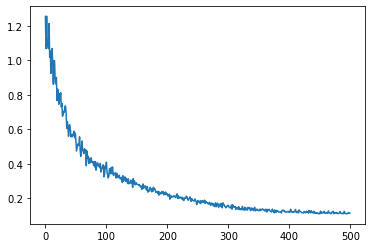

In [6]:
plt.plot(r_list)

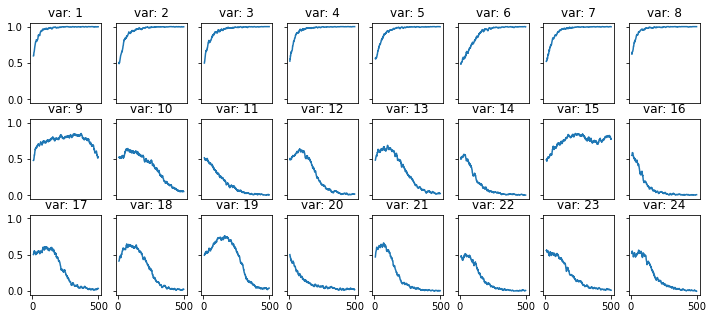

In [7]:
fig, axes = plt.subplots(int(n/8), 8, figsize=(12, 5), sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(int(n/8)):
    for j in range(8):
        axes[i, j].plot(pd.Series(np.array(action_select)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1